In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

Generate sine wave data, store in `x_train`, `y_train`, `x_test`, `x_actual`, make plot. 

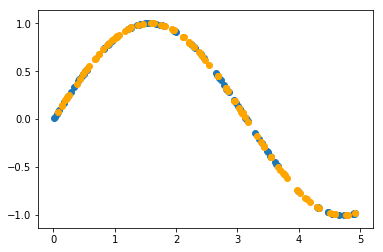

In [9]:
n_train = 100 #number training points
n_test = 100 #number testing points
n_f = n_train + n_test
n_in = 1 #number input features per point
n_out = 1 #number output features per point
n = n_in + n_out

noise, xrange = 0.1, 5
alldata = np.zeros((n, n_f))
alldata[:n_in] = np.random.rand(n_in, n_f) * xrange
alldata[n_in:] = np.sin(alldata[:n_in])# + np.random.normal(scale=noise,size=(n_out,n_f))

x_train = alldata[:n_in, :n_train].reshape(-1,1)
y_train = alldata[n_in:, :n_train].reshape(-1,1)
x_test = alldata[:n_in, n_train:].reshape(-1,1)
y_actual = alldata[n_in:, n_train:].reshape(-1,1)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_actual, color='orange')

Train neural network on data

In [10]:
def nn_mse(x_train, y_train, x_test, y_actual, units=20, epochs=100):
    model = Sequential()
    model.add(Dense(units, input_dim=1, activation='sigmoid'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    model.fit(x_train.flatten(), y_train, epochs=epochs, batch_size=32, verbose=False)
    y_preds = model.predict(x_test)
    
    return np.mean((y_preds - y_actual) ** 2)
    #plt.scatter(x_test, y_preds, color='orange')

#nn_error(x_train, y_train, x_test, y_actual, units=20, epochs=100)

Train sigmoidal transfer kernel GP on data

In [15]:
def sigtransfer_mse(x_train, y_train, x_test, y_actual, noise=0.01, mean=0):
    
    #squared exponential covariance function
    def sq_exp(xp, xq, length_scale=0.01): 
        return np.exp(-length_scale*np.linalg.norm(xp-xq)**2)

    #Sigmoidal transfer function as in [CKI Williams, 1997]
    def sig_transfer(xp, xq):
        prior = np.identity(len(xp))
        inner_pq = xp.reshape(-1,1).T @ prior @ xq.reshape(-1,1)
        inner_pp = xp.reshape(-1,1).T @ prior @ xp.reshape(-1,1)
        inner_qq = xq.reshape(-1,1).T @ prior @ xq.reshape(-1,1)
        norm = np.sqrt((1 + 2 * inner_pp) * (1 + 2 * inner_qq))
        return 2 / np.pi * np.arcsin((2 * inner_pq) / norm)

    noise = noise
    k = sig_transfer

    def getK(Xp, Xq):
        Xp, Xq = Xp.T, Xq.T
        assert Xp.shape[0] == Xq.shape[0], 'Xp, Xq have different numbers of features'
        K=np.zeros((Xp.shape[1],Xq.shape[1]))
        for i in range(K.shape[0]):
            for j in range(K.shape[1]):
                K[i,j] = sig_transfer(Xp[:,i], Xq[:,j])
        return K

    m = mean #prior mean

    K = getK(x_train, x_train)
    L = np.linalg.cholesky(K + np.identity(n_train) * noise)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train - m))
    K_train_test = getK(x_train, x_test)
    pred_mean = K_train_test.T @ alpha + m
    v = np.linalg.solve(L, K_train_test) #covariances
    pred_var = getK(x_test, x_test) - v.T @ v
    log_marginal = -0.5 * y_train.T @ alpha - np.sum(np.log(np.diag(L))) - 0.5*n_train * np.log(2*np.pi)
    
    return np.mean((pred_mean - y_actual) ** 2)

#sigtransfer_mse(x_train, y_train, x_test, y_actual, noise=0.01, mean=0)

In [19]:
e2 = sigtransfer_mse(x_train, y_train, x_test, y_actual, noise=0.01, mean=0)
e2

0.00945999851327006

In [18]:
unit_vals = np.arange(1,300,40)
err_diffs = []

for units in unit_vals:
    e1 = nn_mse(x_train, y_train, x_test, y_actual, units=units, epochs=1000)
    err_diffs.append(e1-e2)
    plt.close()
    print('Number hidden units:', units, '. MSE difference:', e1 - e2)

Number hidden units: 1 . MSE difference: 0.08835533493696837
Number hidden units: 41 . MSE difference: 0.01905650923656435
Number hidden units: 81 . MSE difference: 0.10243668964396364
Number hidden units: 121 . MSE difference: 0.09742959403546284
Number hidden units: 161 . MSE difference: 0.0528839476451617
Number hidden units: 201 . MSE difference: 0.06494981113304268
Number hidden units: 241 . MSE difference: 0.08198837622190401
Number hidden units: 281 . MSE difference: 0.030728892547684912


In [1]:
e2

NameError: name 'e2' is not defined

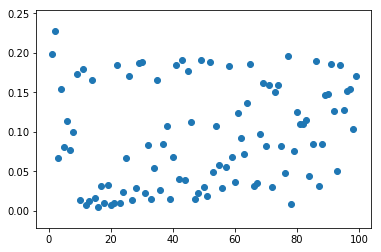

In [82]:
plt.scatter(unit_vals, err_diffs)

Test output (y-value) is at index 30 in chart below. Blue point is actual, orange is predicted. Error bar is 2 SDs. 

<ErrorbarContainer object of 3 artists>

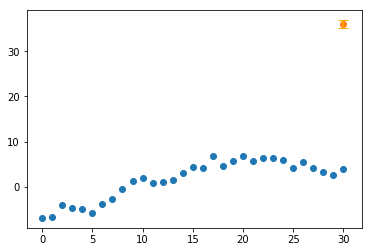

In [84]:
plt.close()
plt.scatter(np.arange(n), alldata[:,-1])
plt.scatter(n_in, pred_mean)
plt.errorbar(n_in, pred_mean, yerr=2*np.sqrt(pred_var), capsize=5, ecolor='orange')